(256, 216, 3)


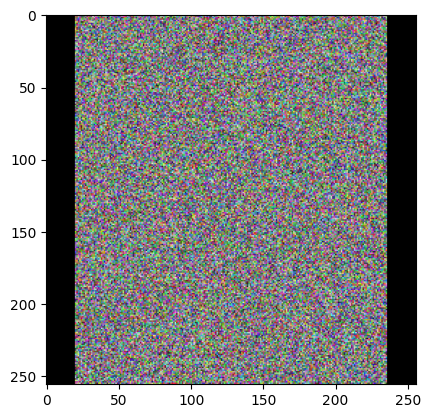

In [1]:
from src.dl_data_pipeline.validator import TypeValidator, ShapeValidator, MinMaxValidator, MeanVarValidator
from src.dl_data_pipeline.pipeline.pipe_node import PipeNode
from src.dl_data_pipeline.pipeline.data_pipeline import Pipeline
from src.dl_data_pipeline import deferred_execution, InputNode
from src.dl_data_pipeline.process_functions import (any_process, process_2d)
import numpy as np

@deferred_execution
def print_infos(x):
    print(x.shape)
    return x

input1 = PipeNode(name = "Input1")
x = any_process.rescale(input1, 0, 1)
x = process_2d.resize_with_max_distortion(x, (256, 256), 0.5)
x = print_infos(x)
x = process_2d.padding_2d(x, (256, 256), 0)

pipe = Pipeline([input1], x)
pipe.add_validator(TypeValidator(np.ndarray), 0)
pipe.add_validator(ShapeValidator((256, 256, 3)), 0)

import matplotlib.pyplot as plt
plt.imshow(pipe(np.random.rand(1920, 1080, 3)))

In [3]:
input_node = InputNode()
x = pipe.as_deferred(input_node)

pipe2 = Pipeline(input_node, x)


In [7]:
pipe2(np.random.rand(25, 25, 3))

(256, 256, 3)


array([[[0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        ...,
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ]],

       [[0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        ...,
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ]],

       [[0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        [0.73693729, 0.90589412, 0.7177171 ],
        ...,
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ],
        [0.72449416, 0.90892855, 0.6609167 ]],

       ...,

       [[0.78897931, 0.36877139, 0.49782373],
        [0.78897931, 0.36877139, 0.49782373],
        [0.78897931, 0